In [3]:
# Install dependencies (only needed once in Colab)
!pip install pandas matplotlib seaborn scikit-learn --quiet


In [5]:
# Remove -1 entries
df = df[df['Salary Estimate'] != '-1']

# Flags for hourly and employer provided
df['hourly'] = df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df['employer_provided'] = df['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary' in x.lower() else 0)

# Salary parsing function
def parse_salary(s):
    s = s.split('(')[0].lower()
    s = s.replace('k', '').replace('$', '').replace('per hour', '')
    s = s.replace('employer provided salary:', '').replace('employer provided salary', '')
    s = s.strip()

    try:
        min_sal, max_sal = s.split('-')
        return int(min_sal.strip()), int(max_sal.strip())
    except:
        return np.nan, np.nan

# Apply function
df['min_salary'], df['max_salary'] = zip(*df['Salary Estimate'].apply(parse_salary))
df = df.dropna(subset=['min_salary', 'max_salary'])
df['avg_salary'] = (df['min_salary'] + df['max_salary']) / 2

df[['Salary Estimate', 'min_salary', 'max_salary', 'avg_salary']].head()


,Salary Estimate,min_salary,max_salary,avg_salary
0,$53K-$91K (Glassdoor est.),53,91,72.0
1,$63K-$112K (Glassdoor est.),63,112,87.5
2,$80K-$90K (Glassdoor est.),80,90,85.0
3,$56K-$97K (Glassdoor est.),56,97,76.5
4,$86K-$143K (Glassdoor est.),86,143,114.5


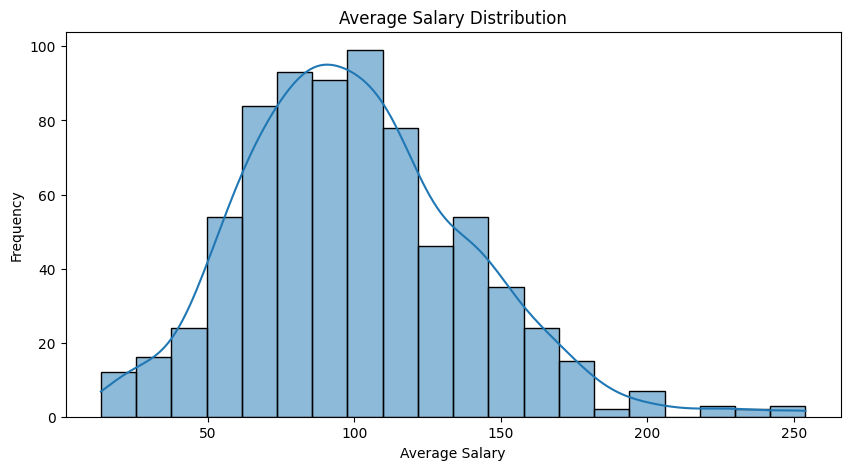

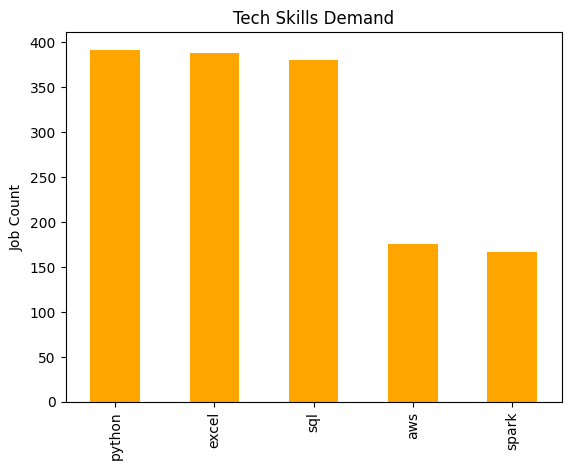

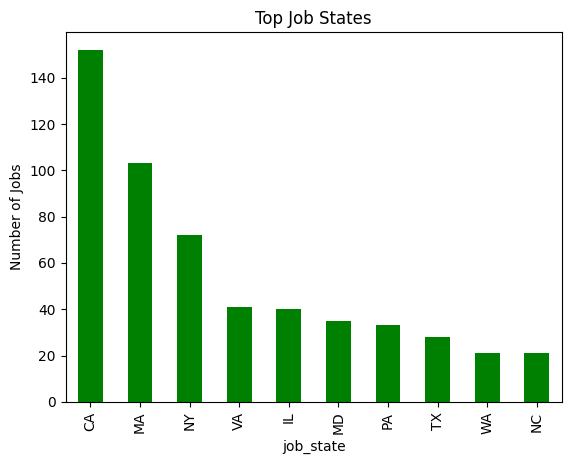

In [7]:
# Salary Distribution
plt.figure(figsize=(10,5))
sns.histplot(df['avg_salary'], bins=20, kde=True)
plt.title('Average Salary Distribution')
plt.xlabel('Average Salary')
plt.ylabel('Frequency')
plt.show()

# Skills Bar Chart
skills = ['python', 'excel', 'aws', 'spark', 'sql']
skill_counts = df[skills].sum().sort_values(ascending=False)
skill_counts.plot(kind='bar', title='Tech Skills Demand', color='orange')
plt.ylabel("Job Count")
plt.show()

# Top Job Locations
top_states = df['job_state'].value_counts().head(10)
top_states.plot(kind='bar', title='Top Job States', color='green')
plt.ylabel("Number of Jobs")
plt.show()


In [13]:
!pip install xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

from google.colab import files
uploaded = files.upload()
df = pd.read_csv("glassdoor_jobs.csv")
df.head()


Saving glassdoor_jobs.csv to glassdoor_jobs (3).csv


,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


In [14]:
df = df[df['Salary Estimate'] != '-1']
df['hourly'] = df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df['employer_provided'] = df['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary' in x.lower() else 0)

def parse_salary(s):
    s = s.split('(')[0].lower()
    s = s.replace('k', '').replace('$', '').replace('per hour', '')
    s = s.replace('employer provided salary:', '').replace('employer provided salary', '').strip()
    try:
        min_sal, max_sal = s.split('-')
        return int(min_sal.strip()), int(max_sal.strip())
    except:
        return np.nan, np.nan

df['min_salary'], df['max_salary'] = zip(*df['Salary Estimate'].apply(parse_salary))
df = df.dropna(subset=['min_salary', 'max_salary'])
df['avg_salary'] = (df['min_salary'] + df['max_salary']) / 2


In [15]:
df['company_txt'] = df.apply(lambda x: x['Company Name'] if x['Rating'] < 0 else x['Company Name'][:-3], axis=1)
df['job_state'] = df['Location'].apply(lambda x: x.split(',')[-1].strip())
df['company_age'] = df['Founded'].apply(lambda x: 2023 - x if x > 0 else -1)
df['python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['excel'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
df['aws'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
df['spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
df['sql'] = df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
df['seniority'] = df['Job Title'].apply(lambda x: 1 if 'senior' in x.lower() or 'lead' in x.lower() else 0)
df['remote'] = df['Job Description'].apply(lambda x: 1 if 'remote' in x.lower() else 0)
df['job_title_simplified'] = df['Job Title'].apply(lambda x: x.split()[0].lower())

df = pd.get_dummies(df, columns=['job_state', 'job_title_simplified'], drop_first=True)


In [16]:
q1 = df['avg_salary'].quantile(0.25)
q3 = df['avg_salary'].quantile(0.75)
iqr = q3 - q1
df = df[(df['avg_salary'] >= (q1 - 1.5 * iqr)) & (df['avg_salary'] <= (q3 + 1.5 * iqr))]


In [19]:
# Ensure only numeric features for XGBoost
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Train the model
model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R2 Score: 0.4814907082584663
RMSE: 24.694306762358384


In [20]:
df['rating_x_age'] = df['Rating'] * df['company_age']
df['senior_python'] = df['seniority'] * df['python']


In [21]:
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [22]:
model = XGBRegressor(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [23]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

estimators = [
    ('rf', RandomForestRegressor(n_estimators=200)),
    ('xgb', XGBRegressor(n_estimators=300))
]

model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge()
)


In [24]:
# STEP 1: Define target variable
target = df['avg_salary']

# STEP 2: Define feature set — drop all salary-related columns
leakage_columns = ['avg_salary', 'min_salary', 'max_salary', 'Salary Estimate']

# Also exclude identifiers and non-informative columns
non_features = [
    'Company Name', 'Location', 'Headquarters', 'Job Description',
    'Competitors', 'company_txt'
]

# Combine columns to drop
columns_to_drop = [col for col in leakage_columns + non_features if col in df.columns]

# STEP 3: Drop leakage-prone columns
X = df.drop(columns=columns_to_drop)

# Optional: Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# STEP 4: Split clean data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# STEP 5: Confirm no leakage columns
print("Columns in training data:", X_train.columns.tolist())
assert not any(col in X_train.columns for col in leakage_columns), "❌ Leakage detected!"
print("✅ No data leakage found in features.")


Columns in training data: ['Unnamed: 0', 'Rating', 'Founded', 'hourly', 'employer_provided', 'company_age', 'python', 'excel', 'aws', 'spark', 'sql', 'seniority', 'remote', 'job_state_AZ', 'job_state_CA', 'job_state_CO', 'job_state_CT', 'job_state_DC', 'job_state_DE', 'job_state_FL', 'job_state_GA', 'job_state_IA', 'job_state_ID', 'job_state_IL', 'job_state_IN', 'job_state_KS', 'job_state_KY', 'job_state_LA', 'job_state_MA', 'job_state_MD', 'job_state_MI', 'job_state_MN', 'job_state_MO', 'job_state_NC', 'job_state_NE', 'job_state_NJ', 'job_state_NM', 'job_state_NY', 'job_state_OH', 'job_state_OR', 'job_state_PA', 'job_state_RI', 'job_state_SC', 'job_state_TN', 'job_state_TX', 'job_state_UT', 'job_state_VA', 'job_state_WA', 'job_state_WI', 'job_title_simplified_analytics', 'job_title_simplified_assistant', 'job_title_simplified_associate', 'job_title_simplified_associate,', 'job_title_simplified_bi', 'job_title_simplified_big', 'job_title_simplified_business', 'job_title_simplified_clin

In [34]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# More aggressive hyperparameter tuning
model = XGBRegressor(
    n_estimators=2000,          # Increased boosting rounds
    max_depth=14,               # Deeper trees to capture complexity
    learning_rate=0.015,        # Slower but more accurate learning
    subsample=0.8,              # Random sampling for generalization
    colsample_bytree=0.9,       # Use more features per tree
    gamma=0,                    # Minimum loss reduction to make a split
    min_child_weight=1,         # Minimum sum of instance weight
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1.0,             # L2 regularization
    random_state=42,
    n_jobs=-1                   # Use all CPU cores
)

# Fit the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("✅ Final Tuned Model Evaluation:")
print("R² Score:", round(r2, 4))
print("RMSE:", round(rmse, 2))


✅ Final Tuned Model Evaluation:
R² Score: 0.7192
RMSE: 18.17


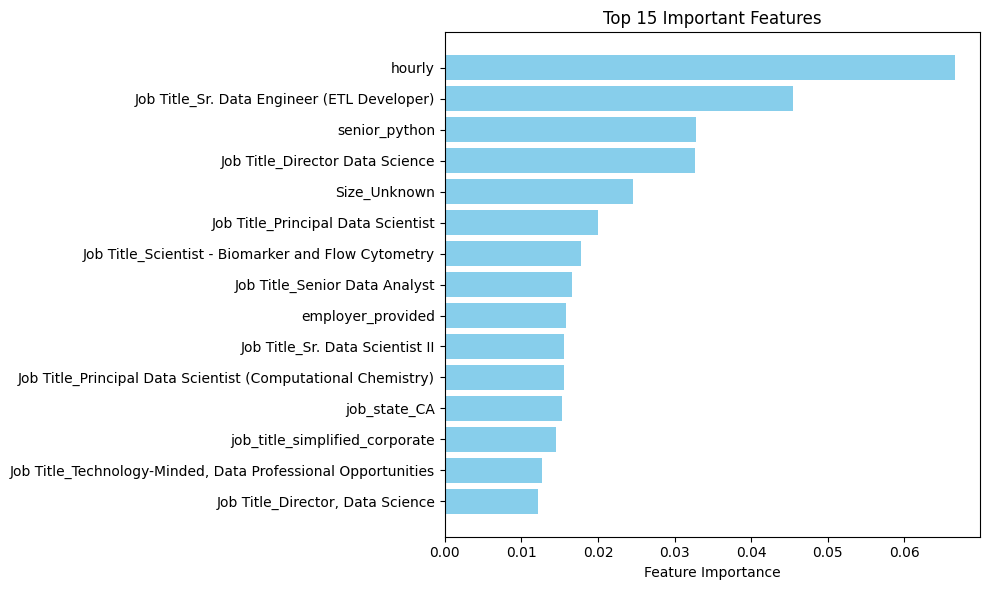

In [26]:
import matplotlib.pyplot as plt

# Get top 15 most important features
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]
features_top = X_train.columns[indices]

plt.figure(figsize=(10,6))
plt.barh(features_top, importances[indices], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.show()
